In [5]:
"""
plot the time series of media storms identified from April 1, 2020 - December 1, 2021
"""

'\nplot the time series of media storms identified from April 1, 2020 - December 1, 2021\n'

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [7]:
STORMS_PATH  = "/shared/3/projects/newsDiffusion/data/processed/stormDfs/20000_90_storms.tsv"
ARTICLES_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWith20000.tsv"

stormsDf = pd.read_csv(STORMS_PATH, sep="\t")
artDf = pd.read_csv(ARTICLES_PATH, sep="\t")

artDf = artDf.drop(columns=["Unnamed: 0"])
stormsDf = stormsDf.drop(columns=["Unnamed: 0"])

SCOL = "20000_90"
stormsDf[SCOL + "_storm"] = True

merged = pd.merge(artDf, stormsDf.drop(columns=[SCOL]), on="key", how="left")

#important: remove any dates before our first local date 
merged = merged[merged["date"] >= "2020-04-01"]


<ipython-input-7-d15d318dab54>:5: DtypeWarning: Columns (4,5,12,13,15,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  artDf = pd.read_csv(ARTICLES_PATH, sep="\t")


In [8]:
#shouldn't have filtered on string up above but it did the job 
merged["date"] = pd.to_datetime(merged["date"])

In [9]:
#get each date as a date since the first story in our data 
#get the first date in our dataset 
minDate = min(merged["date"])

merged["dateInt"] = merged["date"].apply(lambda x: (x - minDate) / np.timedelta64(1, "D"))

In [10]:
SCOL = "20000_90"

In [11]:
#get largest stories 
sClustDf = merged[["source", SCOL, "national", "key", "content", "title", "date", "dateInt", "state", "lat", "lon"]].groupby(SCOL).agg(list).reset_index()
sClustDf["clustSize"] = sClustDf["key"].apply(len)
sClustDf["nationalPercent"] = sClustDf["national"].apply(np.mean)
sClustDf["duration"] = ((sClustDf["date"].apply(max) - sClustDf["date"].apply(min)) / np.timedelta64(1, "D")) + 1

def getUnique(inList): 
        return len(set([item for item in inList if item == item]))
    
#get the number of unique states in this story 
sClustDf["numStates"] = sClustDf["state"].apply(getUnique)

In [22]:
sClust

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'key', 'local_id', 'sourcedomain_id',
       'date', 'title', 'content', 'url', 'fips', 'source', 'description',
       'onlinesince', 'rank', 'state', 'city', 'lon', 'lat', 'county',
       'total_population', 'white_pct', 'black_pct', 'hispanic_pct',
       'nonwhite_pct', 'foreignborn_pct', 'female_pct', 'age29andunder_pct',
       'age65andolder_pct', 'median_hh_inc', 'clf_unemploy_pct', 'lesshs_pct',
       'lesscollege_pct', 'lesshs_whites_pct', 'lesscollege_whites_pct',
       'rural_pct', 'ruralurban_cc', 'predrt_0', 'predrt_12', 'predrt_3',
       'national', 'id', 'author', 'published', 'published_utc',
       'collection_utc', '20000_80', '20000_85', '20000_90', 'year',
       '20000_90_average_pct', '20000_90_num_over_cutoff',
       '20000_90_storm_source', '20000_90_storm', 'dateInt'],
      dtype='object')

In [20]:
#get largest stories 
clustDf = merged[["source", "clustNum", "national", "key", "content", "title", "date", "dateInt", "state", "lat", "lon"]].groupby("clustNum").agg(list).reset_index()
clustDf["clustSize"] = clustDf["key"].apply(len)
clustDf["nationalPercent"] = clustDf["national"].apply(np.mean)
clustDf["duration"] = ((clustDf["date"].apply(max) - clustDf["date"].apply(min)) / np.timedelta64(1, "D")) + 1

def getUnique(inList): 
        return len(set([item for item in inList if item == item]))
    
#get the number of unique states in this story 
clustDf["numStates"] = clustDf["state"].apply(getUnique)

KeyError: "['clustNum'] not in index"

In [ ]:
#get variance of our date integer 
clustDf["dateStd"] = clustDf["dateInt"].apply(np.std) 

In [ ]:
#consideration: maybe make a cutoff using the variance of news story duration? 

In [ ]:
#political unrest in Belarus 
#nashville bombing 
#couple pointing guns at protestors 

In [19]:
#get the top stories in long format so we can plot their times series 
def generateTopStories(clustDf, topStoryNum, sortCol): 
    
    #typically sortCol will be "clustSize", but can also be spike size or something else 
    #get top number of stories for this column 
    topStories = clustDf.sort_values(sortCol, ascending=False).head(topStoryNum)

    #return the date ints that has the highest frequency in the inList of date ints 
    def maxDateInt(inList): 
        return Counter(inList).most_common()[0][0]

    #this will be used to sort stories by their peaks 
    topStories["topDay"] = topStories["dateInt"].apply(maxDateInt)

    def getUnique(inList): 
        return len(set([item for item in inList if item == item]))
    
    #explode stories out from the story level, then group back again at the story,day level 
    topStories = topStories.explode(["source", "national", "key", "content", "title", "date", "dateInt", "lat", "lon", "state"])
    topStoriesDaily = topStories[[SCOL, "dateInt", "key", "topDay", "lat", "lon", "state"]].groupby([SCOL, "dateInt"])\
    .agg({"key":len, "topDay":list, "state":getUnique, "lat":list, "lon":list}).reset_index()

    topStoriesDaily["topDay"] = topStoriesDaily["topDay"].apply(lambda x: x[0])
    
    return topStoriesDaily 


In [181]:
def plotTopStories(topStoriesDaily,  savePath): 
    outTups = []
    fig, ax = plt.subplots(figsize=(12, 3.5))
    palette = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf']
    
    #set things up so we can plot in terms of dates 
    def toDate(dayInt): 
        return fDay + datetime.timedelta(days=dayInt)
    
    #first day is April 1st, 2020
    fDay = datetime.datetime(2020, 4, 1)
    
    #dateRange = date = pd.date_range(fDay, fDay + datetime.timedelta(maxDayInt), max(topStoriesDaily["dateInt"])freq='1min').tolist()
    
    for i, clustNum in enumerate(topStoriesDaily.sort_values("topDay", ascending=True)[SCOL].unique()): 
        currColor = palette[i % len(palette)]
        currStories = topStoriesDaily[topStoriesDaily[SCOL] == clustNum] #.drop(columns=["key"])

        #get the day ints that we need to fill in
        lastDay = max(merged["dateInt"])
        missingDays = set(range(0, int(lastDay))) - set(currStories["dateInt"].unique())

        #a dataframe to fill in missing days with 0 stories 
        topDay = list(currStories["topDay"])[0]
        missingDaysDf = pd.DataFrame({SCOL:clustNum, "dateInt":list(missingDays), "key":0, "topDay":topDay})
        currStories = pd.concat([currStories, missingDaysDf], axis=0).sort_values("dateInt")
        currStories["date"] = currStories["dateInt"].apply(toDate)
        
        ax.plot(currStories["date"], currStories["key"], color=currColor)
        #seaborn version: (same) plot = sns.lineplot(x="dateInt",y="key",data=currStories, alpha=1)
        ax.fill_between(currStories.date.values, currStories.key.values, zorder=i, color=currColor)
        outTups.append((clustNum, currColor, topDay))
    
    maxDayInt = max(topStoriesDaily["dateInt"])
    #ax.set_title(f"Media Storms: April 1, 2020 - December 31, 2021")
    #ax.set_xlabel("day since April 1")
    ax.set_ylabel("# of articles")
    ax.set_xlim(fDay, toDate(maxDayInt))
    ax.set_ylim(0, 305)
    
    date_form = DateFormatter("%b %Y")
    ax.xaxis.set_major_formatter(date_form)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor', size=12) 
    """
    #format x-axis to show date instead of days since April 1, 2020
    fDay = datetime.datetime(2020, 4, 1)
    date_form = DateFormatter("%B %d, %y")
    outLabs = []
    for item in ax.get_xticklabels(): 
        daysPassed = int(item.get_text())
        currDay = fDay + datetime.timedelta(days=daysPassed)
        item.set_text(currDay)
        outLabs.append(item)
    ax.set_xticklabels(outLabs, rotation=45, ha='right', rotation_mode='anchor', size=12) 
    """
    
    
    plt.savefig(savePath, dpi=600, bbox_inches="tight")
    plt.show()
    return (fig, ax)

In [16]:
FIG_PATH = "/home/blitt/projects/localNews/reports/figures/drafts/"
PALETTE = ["#008837", "#7b3294"]

In [17]:
numStorms = len(stormsDf[SCOL].unique())
numStorms

98

<ipython-input-181-8f56af09d805>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor', size=12)


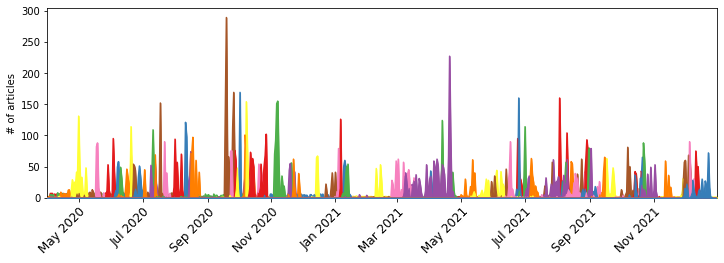

In [182]:
#first, look at all storms 
#commentted out for recreating figure: topStoriesDaily = generateTopStories(sClustDf, numStorms, "clustSize")
outTups = plotTopStories(topStoriesDaily, savePath = FIG_PATH + "allStormsSeries.pdf")

In [176]:
FIG_PATH + "allStormsSeries.pdf"

'/home/blitt/projects/localNews/reports/figures/drafts/allStormsSeries.pdf'